In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import NuestrasFunciones
from sklearn.preprocessing import scale

In [12]:
df_titanic_train = pd.read_csv("Out/df_imputed_transformed_train", index_col = 0)
df_titanic_test = pd.read_csv("Out/df_imputed_transformed_test", index_col = 0)

to_factor = list(df_titanic_train.loc[:,df_titanic_train.nunique() <= 4]);  
df_titanic_train[to_factor] = df_titanic_train[to_factor].astype('category')

to_factor = list(df_titanic_test.loc[:,df_titanic_test.nunique() <= 4]);  
df_titanic_test[to_factor] = df_titanic_test[to_factor].astype('category')

In [13]:
df_titanic_train.Cabin_Letra_Rank.describe()

count    891.000000
mean       3.177329
std        2.188320
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        9.000000
Name: Cabin_Letra_Rank, dtype: float64

### Guianza en este punto sería de mucha ayuda. Pudiese hacer el siguiente split antes o después de pasar los datos crudos por mi pipeline, haciendo que el test set sólo haga transform pero no fit. Sin embargo, dado el pequeño tamaño muestral de algunas categorías, pienso que así es mejor.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_index, test_index in spliter.split(df_titanic_train, df_titanic_train["Survived"]):
        train_set = df_titanic_train.loc[train_index].reset_index().drop("index",axis = 1)
        test_set = df_titanic_train.loc[test_index].reset_index().drop("index",axis = 1)

In [15]:
train_set.dtypes

PassengerId                    int64
Survived                    category
Pclass                      category
Name                          object
Sex                         category
Age                          float64
SiblingsSpouses                int64
ParentsChildren                int64
Ticket                        object
Fare                         float64
Cabin                         object
Embarked                    category
PostTicket                    object
Cant_PersonasMismoTicket       int64
PreTicket                     object
Apellido                      object
Cantidad_MismoApellido         int64
Titulo                        object
Titulo_Expandido              object
Pais                          object
Idioma                        object
Cabin_Letra                   object
PreTicket_Rank                 int64
Titulo_Rank                    int64
Titulo_Expandido_Rank          int64
Cabin_Letra_Rank               int64
Idioma_Rank                    int64
d

<Axes: >

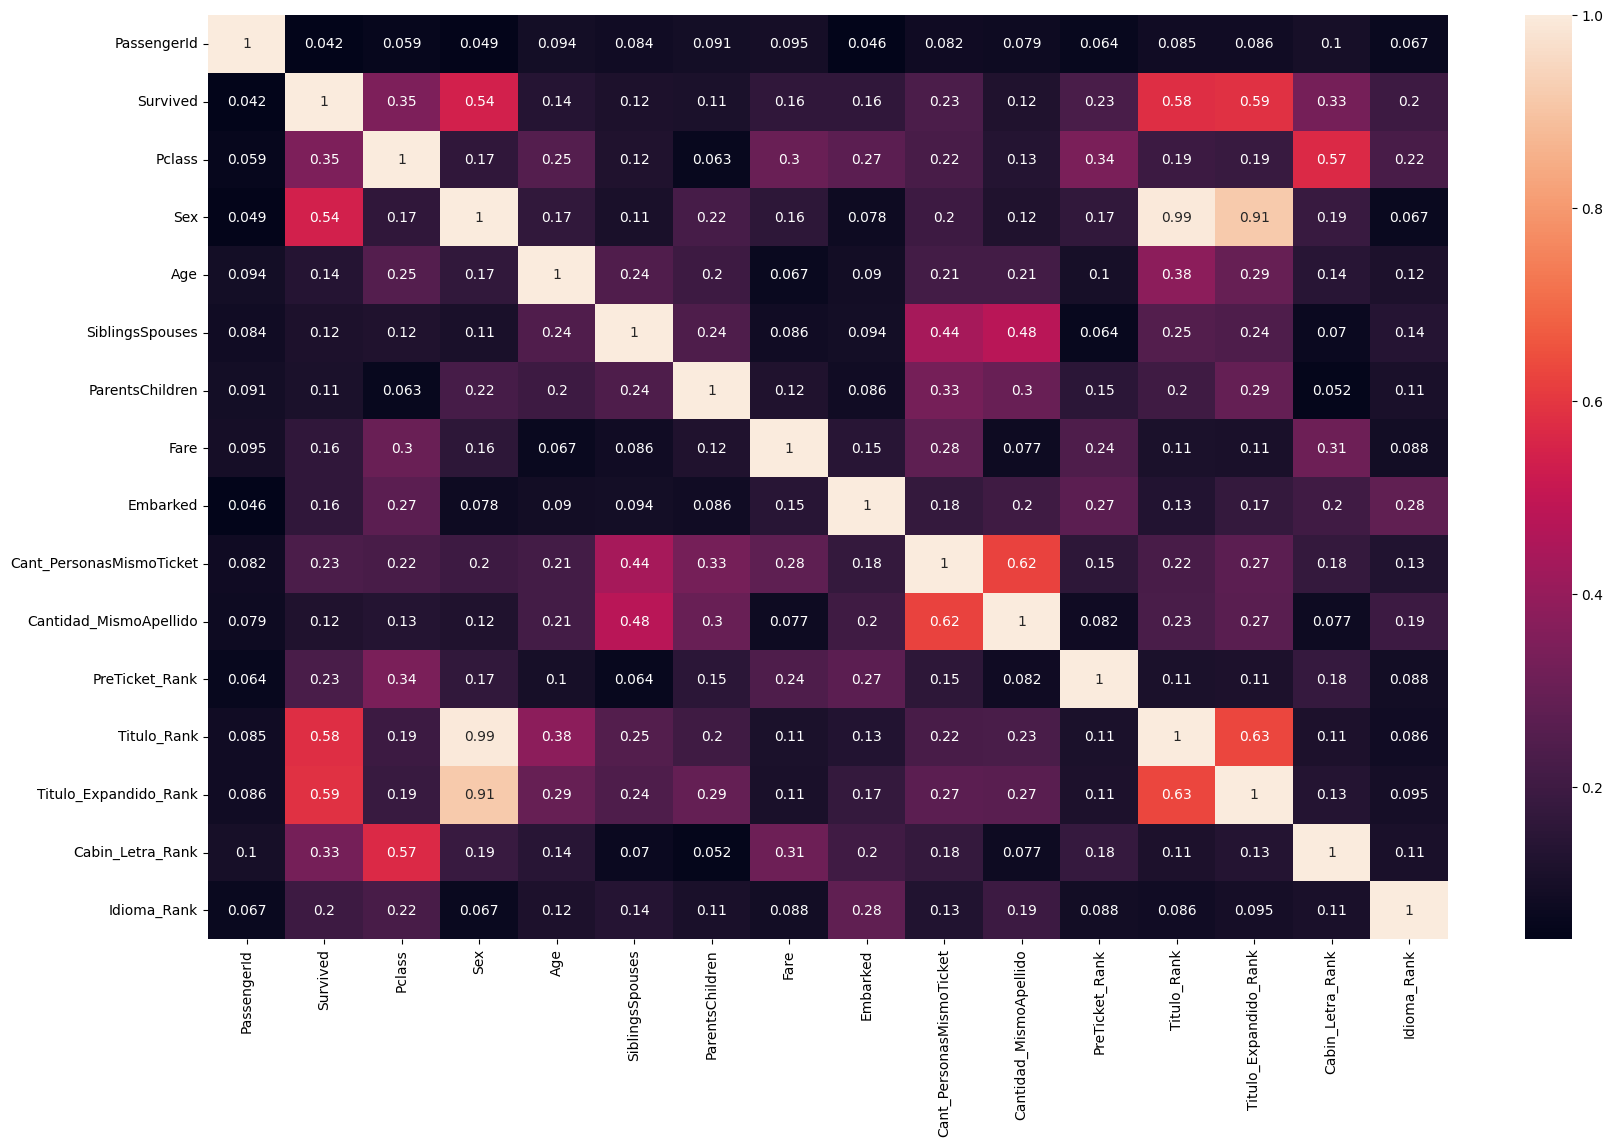

In [16]:
corr = NuestrasFunciones.get_cat_corr_mat(train_set)
plt.rcParams["figure.figsize"] = (20, 12)
sns.heatmap(corr, annot=True)

#### De la matriz de asociación de Cramer podemos sacar muchas conclusiones.
- Nuestros Ranks según título están enormemente correlacionados con el género, parece que el poder de asociación de estos ranks con "Survived" es sólo un poco mayor que el de género.
- Obviamente las variables SiblingSpouse y ParentChildren se correlacionan mucho con cantidad de personas mismo ticket / mismo apellido.
- Tenemos una idea primeriza de cuáles serán nuestros features a utilizar en el modelo.

## Buscaremos ahora transformaciones de nuestras variables continuas que tengan mayor asociación con la objetivo 

In [17]:
def transf_test(df, ser):

    if not isinstance(ser, pd.Series):
        raise ValueError("El input debe ser el df a transformar y el resultado de llamar mejorTransf(name = True).")
        
    for i in ser.values:
        #vv = pd.Series(scale(i), name=i.name)
        #print(vv)
        columna,transformacion = i.split("-")
        
        if transformacion == "ident":
            pass
        elif transformacion == "log":
            df[columna + "-" + transformacion] = np.log(df[columna])
        elif transformacion == "exp":
            df[columna + "-" + transformacion] = np.exp(df[columna])
        elif transformacion == "sqrt":
            df[columna + "-" + transformacion] = np.square(df[columna])
        elif transformacion == "cuarta":
            df[columna + "-" + transformacion] = df[columna]**4
        elif transformacion == "raiz4":
            df[columna + "-" + transformacion] = df[columna]**1/4
            
    return df



In [18]:
train_set.select_dtypes(include = np.number).columns
if 0 in train_set.SiblingsSpouses.values:
    print(2)

2


In [19]:
#train_set.drop("PassengerId",axis = 1).select_dtypes(include = np.number).apply(lambda x: NuestrasFunciones.mejorTransf(x,train_set.Survived, tipo='cramer', name = True, graf = True))

df_transformaciones_nombre = train_set.drop("PassengerId",axis = 1).select_dtypes(include = np.number).apply(lambda x: NuestrasFunciones.mejorTransf(x,train_set.Survived, tipo='cramer', name = True,escalar = False, evita_ceros = True))
df_transformaciones_valores = train_set.drop("PassengerId",axis = 1).select_dtypes(include = np.number).apply(lambda x: NuestrasFunciones.mejorTransf(x,train_set.Survived, tipo='cramer',escalar = False, evita_ceros = True))

df_transformaciones_valores.columns = df_transformaciones_nombre

train_set = pd.concat([train_set, df_transformaciones_valores], axis = 1).drop(["Titulo_Rank-ident"], axis = 1, inplace = False)

test_set = transf_test(test_set,df_transformaciones_nombre)



<Axes: >

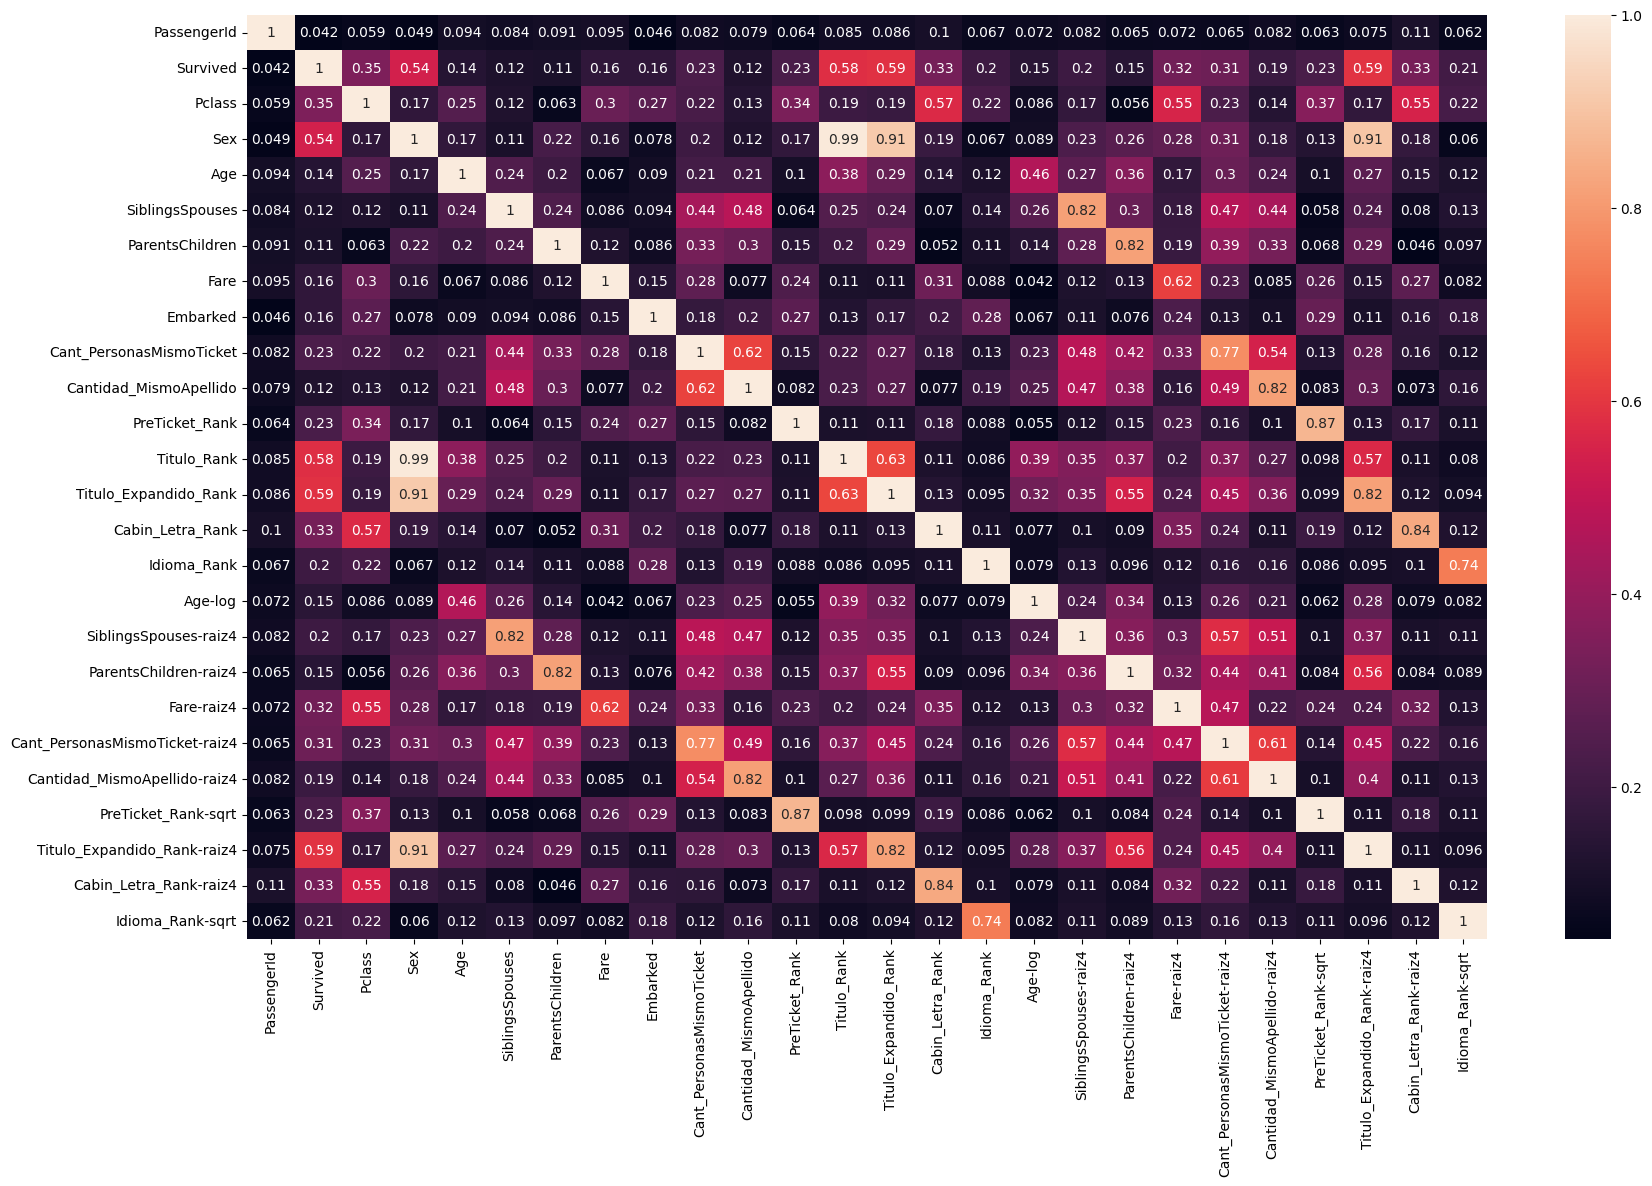

In [21]:
corr = NuestrasFunciones.get_cat_corr_mat(train_set)
plt.rcParams["figure.figsize"] = (20, 12)
sns.heatmap(corr, annot=True)

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

